In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
import logging
import os
from ticker_data import get_df_for_period

tickers = ['AAPL', '^SPX', 'MSFT', '^NDX']
# NDX is an index: volume=0, and High/Low/Open == Close (no intraday range)
#tickers_with_vol  = ['AAPL', '^SPX', '^NDX', 'MSFT']
#tickers_with_ohlc = ['AAPL', '^SPX', '^NDX', 'MSFT']

period_train = {'start': '2019-06-01', 'end': '2025-01-01'}
period_test = {'start': '2025-01-01', 'end': '2025-09-01'}

df_train = get_df_for_period(tickers, period_train)
df_test = get_df_for_period(tickers, period_test)

print(f"Training endet am: {df_train['ds'].max()}")
print(f"Blind-Test startet am: {df_test['ds'].min()}")


[*********************100%***********************]  4 of 4 completed
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
[*********************100%***********************]  4 of 4 completed


unique_id
SPX_vol    2
unique_id
AAPL_price    1405
AAPL_open     1405
AAPL_high     1405
AAPL_low      1405
AAPL_vol      1405
SPX_price     1405
SPX_open      1405
SPX_high      1405
SPX_low       1405
MSFT_price    1405
MSFT_open     1405
MSFT_high     1405
MSFT_low      1405
MSFT_vol      1405
NDX_price     1405
NDX_open      1405
NDX_high      1405
NDX_low       1405
NDX_vol       1405
SPX_vol       1403
Name: count, dtype: int64
Total days: 1405  |  Total rows: 28098  |  Series: 20
y range: [-1.772503, 1.562764]  |  mean: 0.000653  |  std: 0.108334
unique_id
AAPL_price    164
AAPL_open     164
AAPL_high     164
AAPL_low      164
AAPL_vol      164
SPX_price     164
SPX_open      164
SPX_high      164
SPX_low       164
SPX_vol       164
MSFT_price    164
MSFT_open     164
MSFT_high     164
MSFT_low      164
MSFT_vol      164
NDX_price     164
NDX_open      164
NDX_high      164
NDX_low       164
NDX_vol       164
Name: count, dtype: int64
Total days: 164  |  Total rows: 3280  |  Se

In [17]:
from pytorch_lightning.loggers import CSVLogger
my_logger = CSVLogger("logs", name="patchtst_model")

from neuralforecast.losses.pytorch import MAE

import torch 
# Logger wie gehabt
my_logger = CSVLogger("logs", name="patchtst_model")
torch.set_float32_matmul_precision( 'high')
# 2. Modell-Konfiguration

#optuna:
#    Best params: {'input_size': 80, 'patch_len': 8, 'stride': 2, 'encoder_layers': 2, 'n_heads': 4, 'hidden_size': 32, 'linear_hidden_size': 256, 'dropout': 0.11277365231240732, 'learning_rate': 0.0002796795622851195}
#    Best hit rate: 0.738095238095238

model_stable = PatchTST(
    h=7,
    input_size=80,
    patch_len=8,
    stride=2,
    max_steps=1200,           
    learning_rate=0.0002796,
    encoder_layers = 2,
    n_heads = 4,
    hidden_size = 32, 
    linear_hidden_size=256,
    dropout=0.2, 
    #early_stop_patience_steps=5,
    # Early Stopping einbauen
    #early_stop_patience_steps=3, # Stoppt, wenn val_loss 3x hintereinander steigt
    val_check_steps=50,
    #optimizer_kwargs={'weight_decay': 0.01} , #Wir bestrafen das Modell für zu komplexe interne Gewichte. Das zwingt es dazu, einfachere (und damit oft stabilere) Lösungen zu finden.
    accelerator='gpu',
    devices=1,
    logger=my_logger, 
    enable_progress_bar=False,  
)

# 3. NeuralForecast initialisieren
nf_refined = NeuralForecast(models=[model_stable], freq='D')

# 4. Fit ausführen
# Wenn val_size > 0 ist, erkennt Lightning meist automatisch den 'valid_loss'
print("Start training with ", len(df_train), "samples")
print(df_train)
nf_refined.fit(df=df_train, val_size=50)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Start training with  28098 samples
              ds   unique_id         y
0     2019-06-04  AAPL_price  0.035931
1     2019-06-05  AAPL_price  0.016014
2     2019-06-06  AAPL_price  0.014575
3     2019-06-07  AAPL_price  0.026269
4     2019-06-10  AAPL_price  0.012699
...          ...         ...       ...
28095 2024-12-24     NDX_vol -0.364099
28096 2024-12-26     NDX_vol  0.310987
28097 2024-12-27     NDX_vol  0.182789
28098 2024-12-30     NDX_vol  0.076694
28099 2024-12-31     NDX_vol  0.056680

[28098 rows x 3 columns]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 52.1 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 52.1 K                                                                                           
Non-trainable params: 2                                                                                            
Total params: 52.1 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=1200` reached.


logs/patchtst_model/version_5/metrics.csv


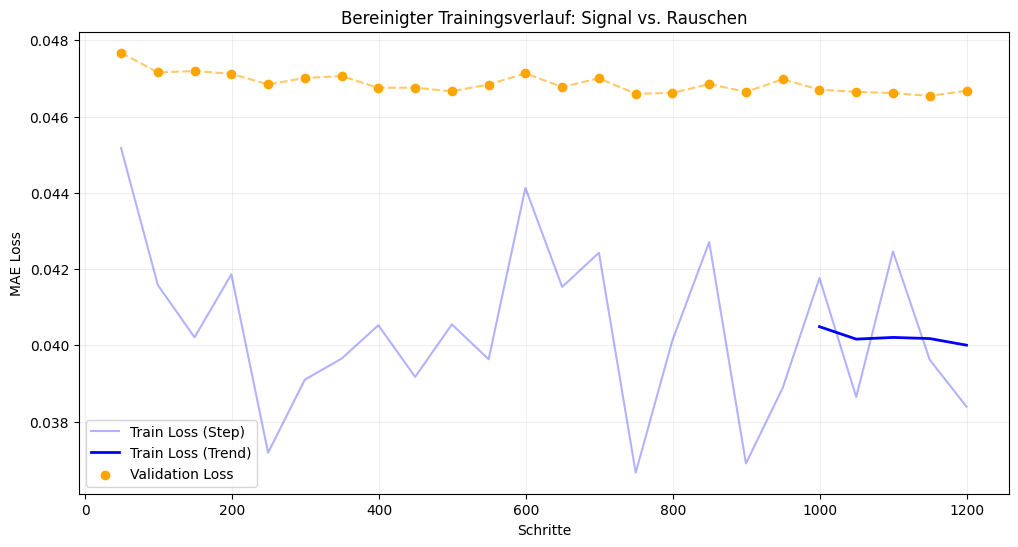

In [18]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
# Nach dem nf.fit(df=train_df, val_size=20) suchen wir die neueste Log-Datei
log_dir = 'logs/patchtst_model/'
latest_log = max(glob.glob(os.path.join(log_dir, 'version_*')), key=os.path.getmtime)
metrics_path = os.path.join(latest_log, 'metrics.csv')

if os.path.exists(metrics_path):
    print(metrics_path)
    # Separate DataFrames für Train und Validation ohne NaNs
    metrics = pd.read_csv(metrics_path)
    train_metrics = metrics[['step', 'train_loss_step']].dropna()
    val_metrics = metrics[['step', 'valid_loss']].dropna()

    plt.figure(figsize=(12, 6))

    # Train Loss (leicht transparent, da verrauscht)
    plt.plot(train_metrics['step'], train_metrics['train_loss_step'], 
            label='Train Loss (Step)', alpha=0.3, color='blue')

    # Rolling Mean zur Visualisierung des Trends
    plt.plot(train_metrics['step'], train_metrics['train_loss_step'].rolling(window=20).mean(), 
            label='Train Loss (Trend)', color='blue', linewidth=2)

    # Validation Loss (deutlich als Punkte)
    plt.scatter(val_metrics['step'], val_metrics['valid_loss'], 
                label='Validation Loss', color='orange', zorder=5)
    plt.plot(val_metrics['step'], val_metrics['valid_loss'], 
            color='orange', linestyle='--', alpha=0.6)

    plt.title('Bereinigter Trainingsverlauf: Signal vs. Rauschen')
    plt.xlabel('Schritte')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
else:
    print("CSV-Metriken nicht gefunden. Stelle sicher, dass 'val_size' beim fit() angegeben wurde.")

In [19]:
# Cross-Validation auf dem noch nie gesehenen Test-Set
df_full = pd.concat([df_train, df_test]).sort_values(['unique_id', 'ds'])
cv_results = nf_refined.cross_validation(df=df_full, 
                                       n_windows=len(df_test['ds'].unique()),  # one window per test day
                                       step_size=1, refit=False )

test_start = df_test['ds'].min()
cv_results = cv_results[cv_results['ds'] >= test_start]

cv_aapl = cv_results[cv_results['unique_id'] == 'AAPL_price'].copy()
cv_aapl_clean = cv_aapl.groupby('cutoff').first().reset_index()

# Trading-Logik: Long-Short
cv_aapl_clean['signal'] = np.where(cv_aapl_clean['PatchTST'] > 0, 1, -1)
cv_aapl_clean['strat_ret'] = cv_aapl_clean['signal'] * cv_aapl_clean['y']

# Kumulative Performance
cv_aapl_clean['cum_strat'] = cv_aapl_clean['strat_ret'].cumsum().apply(np.exp)
cv_aapl_clean['cum_market'] = cv_aapl_clean['y'].cumsum().apply(np.exp)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 52.1 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 52.1 K                                                                                           
Non-trainable params: 2                                                                                            
Total params: 52.1 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=1200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


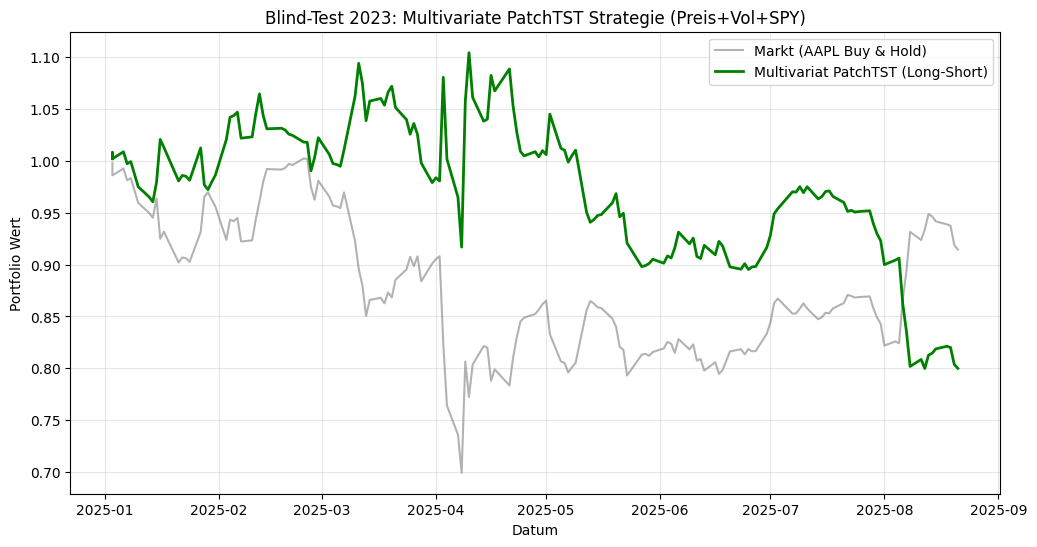

Finale Outperformance (Blind-Test): -11.45 Prozentpunkte


In [20]:
plt.figure(figsize=(12, 6))
plt.plot(cv_aapl_clean['ds'], cv_aapl_clean['cum_market'], label='Markt (AAPL Buy & Hold)', color='gray', alpha=0.6)
plt.plot(cv_aapl_clean['ds'], cv_aapl_clean['cum_strat'], label='Multivariat PatchTST (Long-Short)', color='green', linewidth=2)

plt.title('Blind-Test 2023: Multivariate PatchTST Strategie (Preis+Vol+SPY)')
plt.xlabel('Datum')
plt.ylabel('Portfolio Wert')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Finale Outperformance (Blind-Test): {(cv_aapl_clean['cum_strat'].iloc[-1] - cv_aapl_clean['cum_market'].iloc[-1])*100:.2f} Prozentpunkte")

        cutoff   unique_id         ds  PatchTST         y  signal  strat_ret  \
0   2024-12-20  AAPL_price 2025-01-03 -0.001707 -0.002011      -1   0.002011   
1   2024-12-23  AAPL_price 2025-01-03 -0.000596 -0.002011      -1   0.002011   
2   2024-12-24  AAPL_price 2025-01-03 -0.000376 -0.002011      -1   0.002011   
3   2024-12-26  AAPL_price 2025-01-03 -0.001874 -0.002011      -1   0.002011   
4   2024-12-27  AAPL_price 2025-01-03  0.000232 -0.002011       1  -0.002011   
..         ...         ...        ...       ...       ...     ...        ...   
159 2025-08-14  AAPL_price 2025-08-15 -0.003605 -0.005125      -1   0.005125   
160 2025-08-15  AAPL_price 2025-08-18 -0.001143 -0.003027      -1   0.003027   
161 2025-08-18  AAPL_price 2025-08-19  0.005368 -0.001430       1  -0.001430   
162 2025-08-19  AAPL_price 2025-08-20  0.007649 -0.019932       1  -0.019932   
163 2025-08-20  AAPL_price 2025-08-21  0.001743 -0.004923       1  -0.004923   

     cum_strat  cum_market  
0     1.00

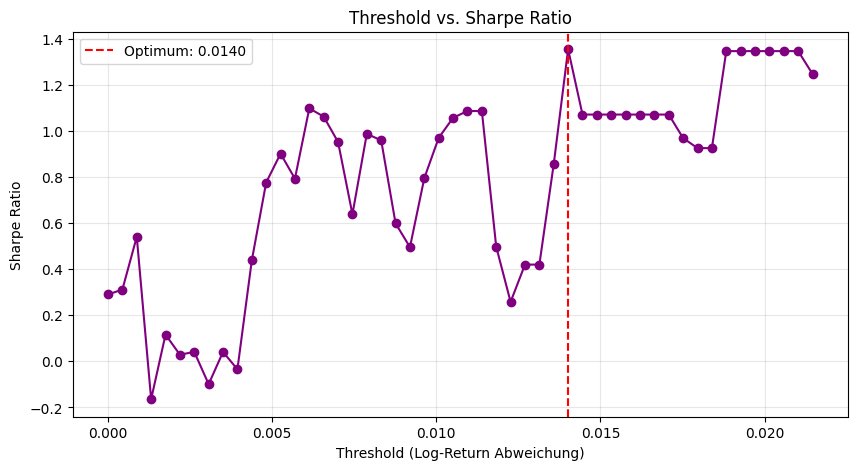

Bester Threshold: 0.014017
Maximale Sharpe Ratio: 1.35
0.014016778


In [31]:
def optimize_threshold(results_df):
    thresholds = np.linspace(0, results_df['PatchTST'].std() * 3, 50)
    best_sharpe = -np.inf
    best_threshold = 0
    results_list = []

    for t in thresholds:
        # Signal berechnen
        sig = np.where(results_df['PatchTST'] > t, 1, 
              np.where(results_df['PatchTST'] < -t, -1, 0))
        
        # Rendite (shifted)
        strat_ret = pd.Series(sig).shift(1).values * results_df['y'].values
        strat_ret = strat_ret[~np.isnan(strat_ret)]
        
        # Sharpe berechnen
        if len(strat_ret) > 0 and strat_ret.std() > 0:
            sharpe = (strat_ret.mean() / strat_ret.std()) * np.sqrt(252)
        else:
            sharpe = 0
            
        results_list.append((t, sharpe))
        
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_threshold = t

    # Visualisierung der Optimierung
    plt.figure(figsize=(10, 5))
    ts, ss = zip(*results_list)
    plt.plot(ts, ss, marker='o', color='purple')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimum: {best_threshold:.4f}')
    plt.title('Threshold vs. Sharpe Ratio')
    plt.xlabel('Threshold (Log-Return Abweichung)')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Bester Threshold: {best_threshold:.6f}")
    print(f"Maximale Sharpe Ratio: {best_sharpe:.2f}")
    return best_threshold


print(cv_aapl_clean)
opt_t = optimize_threshold(cv_aapl_clean)
print(opt_t)

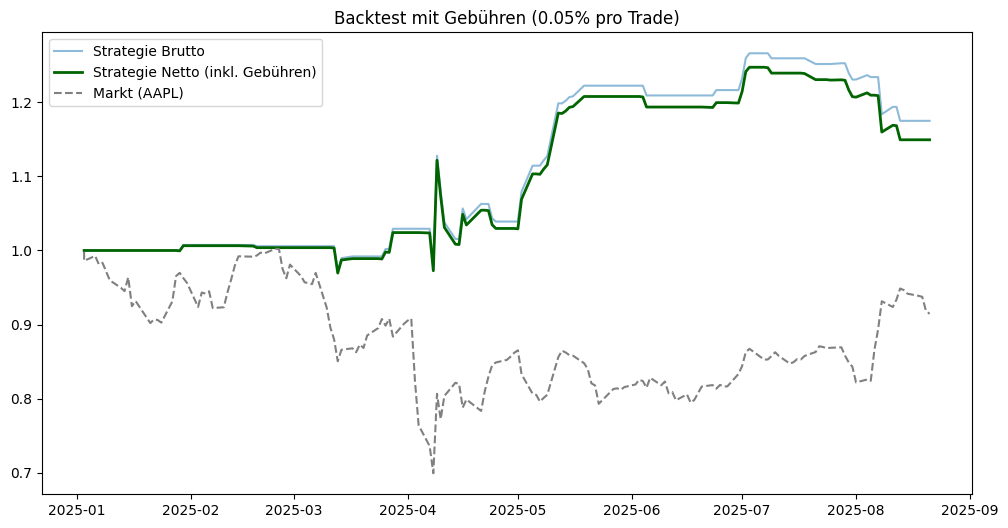

In [38]:
def run_backtest_with_fees(results_df, threshold, fee_per_trade=0.0005):
    """
    Simulation mit Gebühren (0.0005 = 0.05% pro Kauf/Verkauf)
    """
    df = results_df.copy()
    
    # Signal mit optimalem Threshold
    df['signal'] = 0
    df.loc[df['PatchTST'] > threshold, 'signal'] = 1
    df.loc[df['PatchTST'] < -threshold, 'signal'] = -1
    
    # Trades identifizieren (Wechsel des Signals)
    # Ein Trade findet statt, wenn sich das Signal im Vergleich zum Vortag ändert
    df['trade_action'] = df['signal'].diff().abs()
    
    # Brutto-Rendite
    df['strat_ret_brutto'] = df['signal'].shift(1) * df['y']
    
    # Netto-Rendite (Brutto - (Anzahl Trades * Gebühr))
    df['strat_ret_netto'] = df['strat_ret_brutto'] - (df['trade_action'] * fee_per_trade)
    
    # Kumulierte Werte
    df['cum_strat_brutto'] = np.exp(df['strat_ret_brutto'].fillna(0).cumsum())
    df['cum_strat_netto'] = np.exp(df['strat_ret_netto'].fillna(0).cumsum())
    #print(df)
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['cum_strat_brutto'], label='Strategie Brutto', alpha=0.5)
    plt.plot(df['ds'], df['cum_strat_netto'], label='Strategie Netto (inkl. Gebühren)', color='darkgreen', linewidth=2)
    plt.plot(df['ds'], np.exp(df['y'].cumsum()), label='Markt (AAPL)', color='gray', linestyle='--')
    plt.title(f'Backtest mit Gebühren ({fee_per_trade*100:.2f}% pro Trade)')
    plt.legend()
    plt.show()
    
    return df

# Simulation mit 0.05% Gebühren (typisch für viele Online-Broker/Krypto)

df_netto = run_backtest_with_fees(cv_aapl_clean, threshold=0.008, fee_per_trade=0.0005)

In [41]:
#Wir führen eine Confidence-Schwelle ein.
# Wenn das Modell nur eine minimale Bewegung vorhersagt, bleiben wir an der Seitenlinie (Signal 0). Wir handeln nur bei "starken" Vorhersagen.    
# Berechne die Standardabweichung der Vorhersagen, um eine Schwelle zu finden
long_results = df_netto.copy()
threshold = long_results['PatchTST'].std() * 0.5

# Neues Signal-Design:
# 1  bei starkem Aufwärtstrend
# -1 bei starkem Abwärtstrend
# 0  bei Unsicherheit (Rauschen)
long_results['signal_filtered'] = 0
long_results.loc[long_results['PatchTST'] > threshold, 'signal_filtered'] = 1
long_results.loc[long_results['PatchTST'] < -threshold, 'signal_filtered'] = -1

# Neue Performance berechnen
long_results['strat_ret_filtered'] = long_results['signal_filtered'].shift(1) * long_results['y']
long_results['cum_strat_filtered'] = np.exp(long_results['strat_ret_filtered'].cumsum())

def print_stats_filtered(results):
    # Annualisierte Sharpe Ratio (ausgehend von 252 Handelstagen)
    std = results['strat_ret_filtered'].std()
    mean = results['strat_ret_filtered'].mean()
    sharpe = (mean / std) * np.sqrt(252) if std != 0 else 0
    
    # Maximaler Drawdown
    cum_ret = results['cum_strat_filtered']
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    print(f"--- Strategie-Check cum_strat_filtered ---")
    print(f"Sharpe Ratio:      {sharpe:.2f}")
    print(f"Max Drawdown:      {max_dd:.2f}%")
    print(f"Win Rate (Tage):   {(results['strat_ret'] > 0).mean()*100:.1f}%")
    
def print_stats(results):
    # Annualisierte Sharpe Ratio (ausgehend von 252 Handelstagen)
    std = results['strat_ret'].std()
    mean = results['strat_ret'].mean()
    sharpe = (mean / std) * np.sqrt(252) if std != 0 else 0
    
    # Maximaler Drawdown
    cum_ret = results['cum_strat_netto']
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    print(f"--- Strategie-Check unfiltered ---")
    print(f"Sharpe Ratio:      {sharpe:.2f}")
    print(f"Max Drawdown:      {max_dd:.2f}%")
    print(f"Win Rate (Tage):   {(results['strat_ret'] > 0).mean()*100:.1f}%")

print_stats(long_results)
print_stats_filtered(long_results)

--- Strategie-Check unfiltered ---
Sharpe Ratio:      -0.94
Max Drawdown:      -10.14%
Win Rate (Tage):   48.8%
--- Strategie-Check cum_strat_filtered ---
Sharpe Ratio:      0.04
Max Drawdown:      -13.56%
Win Rate (Tage):   48.8%


In [42]:
# Das Modell lokal speichern
nf_refined.save(path='./checkpoints/patchtst_momentum_model_multivar_100days/')

print("Modell erfolgreich gespeichert. Du kannst es nun jederzeit laden.")

Exception: Directory is not empty. Set `overwrite=True` to overwrite files.